In [0]:
%tensorflow_version 2.x

from tensorflow import math as mt
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import tensorflow as tf
import keras
#from keras.layers import LSTM, Dense, Flatten, Dropout, Activation, GRU, TimeDistributed, InputLayer, Conv1D, Conv2D, Conv3D
#from keras.models import Sequential
#from keras.callbacks import EarlyStopping
from keras.optimizers import Adam

from google.colab import drive
drive.mount("/content/gdrive/")

TensorFlow 2.x selected.


Using TensorFlow backend.


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
import sys
sys.path.append('/content/gdrive/My Drive/AutoML/CNN/fridge_freezer')

from x_pipeline import XPipeline
from y_pipeline import YPipeline

In [0]:
X_train = pd.read_csv(
    'gdrive/My Drive/AutoML/data/X_train_6GWGSxz.csv',
)
X_train.set_index("time_step", inplace=True)
Y_train = pd.read_csv(
    'gdrive/My Drive/AutoML/data/y_train_2G60rOL.csv',
)
Y_train.set_index("time_step", inplace=True)

px = XPipeline()
py = YPipeline()

In [0]:
X_train.columns

Index(['consumption', 'visibility', 'temperature', 'humidity', 'humidex',
       'windchill', 'wind', 'pressure', 'Unnamed: 9'],
      dtype='object')

In [0]:
pd.set_option('display.max_columns', None)

## Preprocessing

In [0]:
print('Start of first transform')
x = px.fit(X_train)
x = px.transform(X_train)
print('End of first transform')
y = py.fit(Y_train)
y = py.transform(Y_train)
print('Second transform')
x_train, y_train = x[:321000, :, :], y[:321000]
x_valid, y_valid = x[321000:, :, :], y[321000:]

Start of first transform
End of first transform
Second transform


In [0]:
x.shape

(401759, 120, 1)

In [0]:
print(f"x_train shape is {x_train.shape}")
print(f"x_valid shape is {x_valid.shape}")

x_train shape is (321000, 120, 1)
x_valid shape is (80759, 120, 1)


## CNN

In [0]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.InputLayer(input_shape=[120, 1]))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=6, padding="valid",
                              activation="relu"))
model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding="valid",
                              activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv1D(filters=48, kernel_size=3, padding="valid",
                              activation="relu"))
model.add(tf.keras.layers.Conv1D(filters=48, kernel_size=3, padding="valid",
                              activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dropout(0.25))
model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=2, padding="valid",
                              activation="relu"))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='linear'))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 115, 32)           224       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 113, 32)           3104      
_________________________________________________________________
batch_normalization (BatchNo (None, 113, 32)           128       
_________________________________________________________________
dropout (Dropout)            (None, 113, 32)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 111, 48)           4656      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 109, 48)           6960      
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 48)           1

Metric: Mean Squared Error. Same as minimizing the Metric on the platform.

In [0]:
model.compile(loss=keras.losses.mean_squared_error, optimizer=tf.keras.optimizers.Adam())
history = model.fit(x, y, epochs=4)
# history = model.fit(x_train, y_train, epochs=4,
#                     validation_data=(x_valid, y_valid))

Train on 401759 samples
Epoch 1/4
401759/401759 [==============================] - 82s 204us/sample - loss: 1284.8498
Epoch 2/4
401759/401759 [==============================] - 73s 181us/sample - loss: 940.0572
Epoch 3/4
401759/401759 [==============================] - 73s 181us/sample - loss: 788.1262
Epoch 4/4
401759/401759 [==============================] - 72s 179us/sample - loss: 664.2423


In [0]:
pred_val = model.predict(x_valid)

In [0]:
pred_val[pred_val<0] = 0

### Evaluating Performance

In [0]:
def nilm_metric(y_true, y_pred):
        score = 0.0
        score += math.sqrt(sum((y_pred - y_true) ** 2) / len(y_true)) * 49.79
        score /= 74.86
        return score

In [0]:
nilm_metric(y_valid.values, pred_val)

15.93626100010345

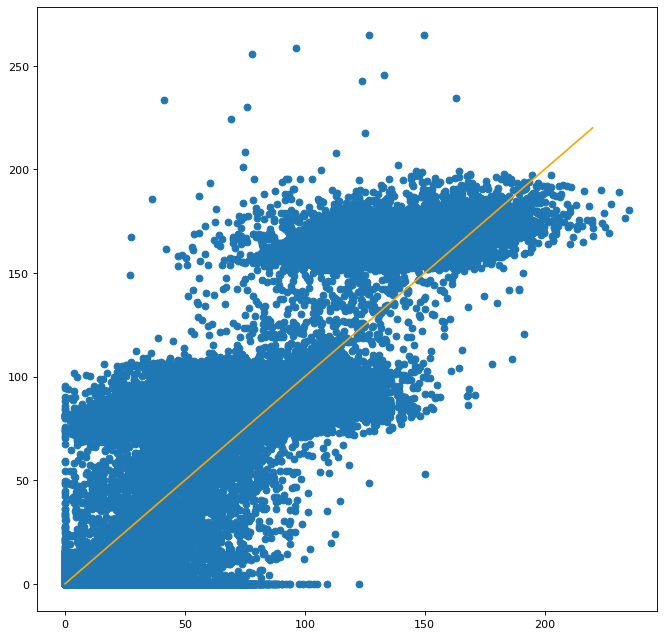

In [0]:
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(pred_val, y_valid)
plt.plot(np.linspace(0,220), np.linspace(0,220), c="orange")
plt.show()

In [0]:
pred_val

array([[71.42562 ],
       [73.86804 ],
       [53.03219 ],
       ...,
       [33.19578 ],
       [34.22797 ],
       [39.357796]], dtype=float32)

### submission

In [0]:
X_test = pd.read_csv(
    'gdrive/My Drive/AutoML/data/X_test_c2uBt2s.csv',
)
time = X_test["time_step"]
X_test.set_index("time_step", inplace=True)

In [0]:
x_test = px.transform(X_test)

In [0]:
pred = model.predict(x_test)
pred[pred<0] = 0
pred = pd.DataFrame(pred, columns=["fridge_freezer"])

In [0]:
pred = pd.concat([time, pred], axis=1)

In [0]:
pred.to_csv("gdrive/My Drive/AutoML/CNN/fridge_freezer/fridge_freezer.csv", index=False)